In [ ]:
%matplotlib inline
import cv2 as cv
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
FACE_DIR = os.path.join(os.getcwd(),"faces") 

In [ ]:
FACE_DIR

In [ ]:
def read_im(path):
    image = PIL.Image.open(path)
    return np.array(image)

In [ ]:
def show_im(image):
    plt.imshow(image,cmap="gray")
    plt.show()


In [ ]:
# For flipping the photos 
"""
for dirpath, dirnames, filenames in os.walk(FACE_DIR):
    for file in filenames:
        im = read_im(os.path.join(dirpath,file)) 
        im = cv.flip(im,1)
        # show_im(im)
        new_file = str(int(file.split('.')[0])+11) + '.png'
        # print(new_file)
        loc = os.path.join(dirpath,new_file)
        print(loc)

"""

In [82]:
SUB = 15    # Number of subjects
IPS = 22    # Images per subject
N = 100     # Width and Height of images
m = SUB*IPS # Total Images

face_mat = np.zeros((m,N,N))

# Getting all images into the face matrix
count = 0
for dirpath, dirnames, filenames in os.walk(FACE_DIR):
    for file in filenames:
        face_mat[count] = read_im(os.path.join(dirpath,file))
        count += 1

In [80]:
def train_test_split(face_mat,Train_per_sub = 20):
    # Train test Split:
    Train_ims = Train_per_sub*SUB           #Total Train Ims
    Test_per_sub = IPS - Train_per_sub
    Test_ims = Test_per_sub*SUB

    train_mat = np.zeros((Train_ims,N,N))
    test_mat = np.zeros((Test_ims,N,N))
    train_count = 0
    test_count = 0

    for count,face in enumerate(face_mat):
        # print(coun)
        if count%IPS <Test_per_sub:
            # print("TEST",count,test_count)
            test_mat[test_count] = face_mat[count]
            test_count += 1
        
        else:
            # print("TRAIN",count,train_count)
            train_mat[train_count] = face_mat[count]
            train_count += 1
    return train_mat,test_mat

Shape of A is  (10000, 300)
Shape of A_avg is  (10000,)
This is the average face-


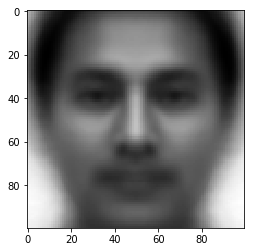

In [83]:
train_per_sub = 20
m = train_per_sub*SUB
face_mat /= 255
train_mat, test_mat = train_test_split(face_mat,train_per_sub)

# We need A of shape (N*N,m)
A = np.reshape(train_mat,(m,N*N)).T
print("Shape of A is ",A.shape)

# Calculating Average Face
A_avg = np.mean(A,axis=1)
print("Shape of A_avg is ",A_avg.shape)
print("This is the average face-")
show_im(np.reshape(A_avg,(N,N)))


In [143]:
# Calculating Normalized Faces
Phi_1 = (A.T - A_avg.T).T
print("Phi_1 shape is ",Phi_1.shape)

# Calculating Average Faces Per Person
Phi_Avg = np.zeros((N*N,SUB))
for i in range(SUB):
    j = Train_per_sub
    Phi_Avg[:,i] = np.mean(Phi_1[:,i*j:(i+1)*j],axis=1)


Phi_1 shape is  (10000, 300)


Cov_mxm shape is  (300, 300)


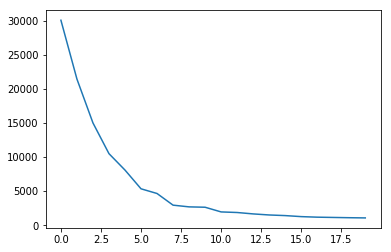

We choose 202 principal components


In [97]:
# Calculating m*m covarience matrices and their eigen values
Cov_mbym = np.dot(Phi_1.T,Phi_1)
print("Cov_mxm shape is ",Cov_mbym.shape)

eig,eig_vec = np.linalg.eig(Cov_mbym)
eig,eig_vec = np.real(eig),np.real(eig_vec)
plt.plot(eig[:20])
plt.show()

# Choosing number of principal components
variance = 0.99
for k in range(len(eig)):
  if np.sum(eig[:k])/np.sum(eig) > variance:
    print("We choose {} principal components".format(k))
    break


(202,) (10000, 202)
These are the top 10 eigen faces


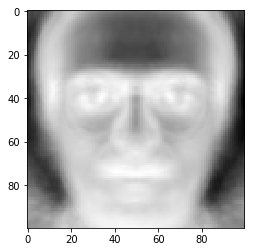

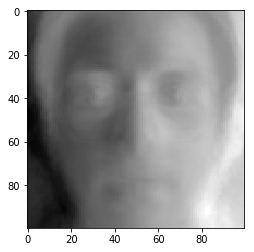

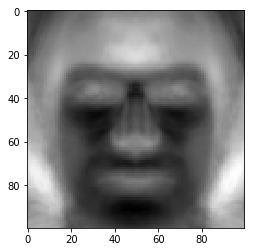

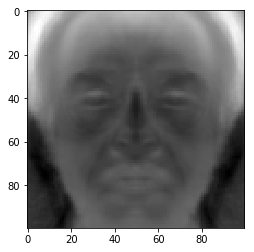

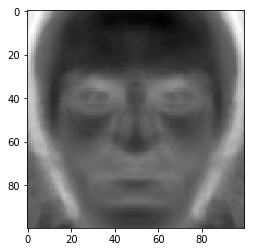

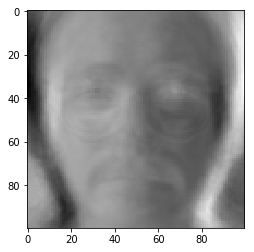

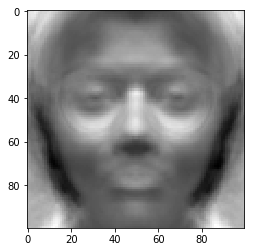

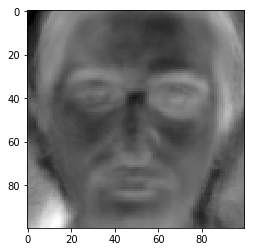

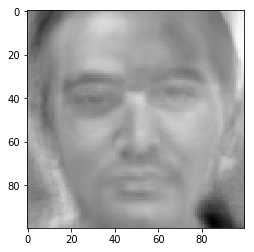

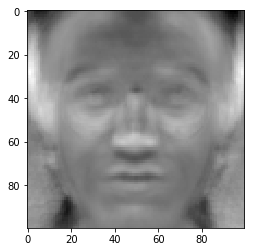

In [98]:
# Selecting K values out of m and dotting N.Nxm with mxk 
eig_k,eig_k_vec = eig[:k],np.dot(Phi_1,eig_vec[:,:k])
print(eig_k.shape,eig_k_vec.shape)

print("These are the top 10 eigen faces")
for i in range(10):
  show_im(np.reshape(eig_k_vec.T[i],(100,100)))


In [117]:
print(Phi_1[:,1].shape,eig_k_vec[:].shape)
Weights,_,_,_ = np.linalg.lstsq(eig_k_vec,Phi_1)

(10000,) (10000, 202)


In [145]:
embedded = np.dot(Phi_1.T,eig_k_vec)
print("Embedding for all faces", embedded.shape)

emb_avg = np.dot(Phi_Avg.T,eig_k_vec)
print("Average Embedding per person shape ",emb_avg.shape)


Embedding for all faces (300, 202)
Average Embedding per person shape  (15, 202)


In [136]:
cov = np.dot(embedded,embedded.T)
cos_mat = np.zeros((m,m))
thres = 0.6
for i in range(m):
  for j in range(m):
    if cos_sim(embedded[i],embedded[j])>thres:
      cos_mat[i,j] = 1 #cos_sim(embedded[i],embedded[j])

&lt;matplotlib.image.AxesImage at 0x21fdfd59128&gt;

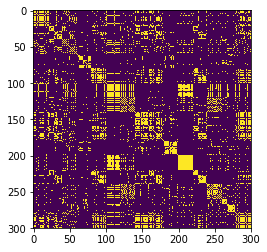

In [137]:
plt.imshow(cos_mat)

In [121]:
def cos_sim(a,b):
  return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [122]:
cos_sim(Weights[:,1],Weights[:,2])

0.0522481684627847

In [127]:
def check_face_all(face,faces,thres=0.6):
    check = np.zeros(SUB)
    
    for i in range(SUB):
        for j in range(train_per_sub):
            if cos_sim(face,faces[i*train_per_sub +j])>thres:
                check[i] += 1
    return np.argmax(check),check

In [142]:
def check_face(face,embed):
    check = []
#     print(face.shape,embed.shape)
    for i in range(len(embed)):
        check.append(cos_sim(face,embed[i]))
    return np.argmax(check),check[np.argmax(check)]

In [150]:
face = embedded
check_face_all(face[20],face,thres=0.8)

(1, array([0., 5., 0., 0., 0., 0., 1., 2., 1., 0., 0., 4., 0., 0., 1.]))

In [183]:
correct = 0
thres = 0.9
mat = np.zeros((2,2))

for i in range(SUB):
    for j in range(Train_per_sub):
        # id,t = check_face_all(embedded[i*Train_per_sub+ j],embedded,thres)
        # print(t)
        id,sim = check_face(embedded[i*Train_per_sub + j],emb_avg)
        if id == i: #id==i: #
            correct += 1
print("Correct = {}, Wrong = {}".format(correct,300-correct))
print("Accuracy = ",correct/300)

Correct = 207, Wrong = 93
Accuracy =  0.69


In [191]:
# Testing Accuracy
print("test_mat shape is ",test_mat.shape)
print("Phi_avg shape is" ,Phi_Avg.shape)

test_A = np.reshape(test_mat,(test_count,N*N)).T
print('Test_A shape is ',test_phi.shape)

test_phi_1 = (test_A.T - A_avg.T).T
print("test_phi_1 shape is",test_phi_1.shape)

# show_im(np.reshape(test_phi_1.T[1],(N,N)))

test_embed = np.dot(test_phi_1.T,eig_k_vec)
print("test_embed shape is ",test_embed.shape)


correct = 0
thres = 0.8

for i in range(SUB):
    for j in range(Test_per_sub):
        id,t = check_face_all(test_embed[i*Test_per_sub+ j],embedded,thres)
        print(t)
        # id,sim = check_face(embedded[i*Train_per_sub + j],emb_avg)
        if id == i: #id==i: #
            correct += 1
print("Correct = {}, Wrong = {}".format(correct,test_count-correct))
print("Accuracy = ",correct/test_count)




test_mat shape is  (30, 100, 100)
Phi_avg shape is (10000, 15)
Test_A shape is  (10000, 30)
test_phi_1 shape is (10000, 30)
test_embed shape is  (30, 202)
[9. 2. 0. 0. 0. 2. 0. 0. 1. 0. 0. 2. 0. 0. 0.]
[8. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0. 6. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2.]
[0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0. 10.  0.  0.  1.  8.  0.  0.  2.  0.  0.  3.]
[ 0.  0.  0.  0. 13.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  1.  0. 14.  1.  0.  0.  0.  9.  0.  0.  0.  0.]
[ 0.  0.  2.  1.  0. 14.  6.  0.  0.  0.  2.  0.  3.  0.  0.]
[0. 0. 0. 0. 0. 0. 9. 0. 0. 0. 0. 0. 7. 0. 0.]
[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 2. 0. 0. 0. 0. 0. 9. 7. 0. 0. 2. 0. 0. 8.]
[0. 0. 1. 0. 0. 0. 0. 3. 0. 1. 0. 0. 0. 0. 0.]
[0. 4. 0. 0. 1. 0. 0. 2. 5. 0. 0.